# Import modules

In [23]:
# basic import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
import math

%matplotlib inline

In [24]:
import spacy
import re

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.metrics import classification_report, balanced_accuracy_score, confusion_matrix
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn.metrics import make_scorer, balanced_accuracy_score

In [41]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, roc_curve, auc

In [26]:
link_train = "./dataset/clean.csv"

In [27]:
train_df =pd.read_csv(link_train, delimiter=",")

In [28]:
train_df.head()

,text,label
0,kunjung prabowo untuk resmi serah proyek bantu...,Sumber Daya Alam
1,anies tepuk tangan riah jadi rektor wajib mata...,Politik
2,benar dukung goblok dukung hanya saja pak ridw...,Demografi
3,waktu anies sikap kritis kerja pak prabowo ang...,Politik
4,anies baswedan harap asn masuk tni polri pegan...,Politik


In [29]:
train_df.nunique()

text     4272
label       8
dtype: int64

In [30]:
train_df['label'].value_counts()

label
Politik                    2895
Sosial Budaya               405
Ekonomi                     278
Pertahanan dan Keamanan     270
Ideologi                    263
Sumber Daya Alam            147
Demografi                    60
Geografi                     20
Name: count, dtype: int64

In [31]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4338 entries, 0 to 4337
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    4333 non-null   object
 1   label   4338 non-null   object
dtypes: object(2)
memory usage: 67.9+ KB


# Preprocessing

In [32]:
robin_df = pd.read_csv('./dictionary/robin_dict.csv')  # Ganti dengan path ke file CSV Anda
robin_dict = dict(zip(robin_df['text lama'], robin_df['text baru']))  

# Ganti nilai NaN dengan string kosong dan pastikan semua nilai adalah string
train_df['text'] = train_df['text'].fillna('').astype(str)

# Membuat regex pattern untuk semua slang
robin = r'\b(?:' + '|'.join(map(re.escape, robin_dict.keys())) + r')\b'

# Fungsi untuk mengganti slang dengan formal
def replace_slang(text):
    return re.sub(robin, lambda match: robin_dict[match.group(0)], text)

# Menerapkan fungsi ke kolom teks
train_df['text'] = train_df['text'].apply(replace_slang)

In [33]:
train_df.isna().sum()

text     0
label    0
dtype: int64

# Training

In [34]:
train_df['stemmed_text'] = train_df['text']
encoding_dict = {
    'Politik':0,
    'Sosial Budaya':1,
    'Pertahanan dan Keamanan':2,
    'Ideologi':3,
    'Ekonomi':4,
    'Sumber Daya Alam':5,
    'Demografi':6,
    'Geografi':7,
}

# Fitting and transforming the 'Category' column
train_df['encoded_label'] = train_df['label'].map(encoding_dict)

In [35]:
train_df.head()

,text,label,stemmed_text,encoded_label
0,kunjungan prabowo untuk resmi serah proyek ban...,Sumber Daya Alam,kunjungan prabowo untuk resmi serah proyek ban...,5
1,anies tepuk tangan riuh jadi rektor wajib mata...,Politik,anies tepuk tangan riuh jadi rektor wajib mata...,0
2,benar dukung goblok dukung hanya saja pak ridw...,Demografi,benar dukung goblok dukung hanya saja pak ridw...,6
3,waktu anies sikap kritis kerja pak prabowo ang...,Politik,waktu anies sikap kritis kerja pak prabowo ang...,0
4,anies baswedan berharap asn masuk tni polri pe...,Politik,anies baswedan berharap asn masuk tni polri pe...,0


In [36]:
# Fitting and transforming the 'Category' column
X_train, X_test, y_train, y_test = train_test_split(
    train_df.stemmed_text,
    train_df.encoded_label,
    test_size=0.2,
    random_state=42,
    stratify=train_df.encoded_label
)

## Base Multinomial Naive Bayes (MultiNB)

In [37]:
mnb_clf = Pipeline([
    ('vectorizer_tfid',TfidfVectorizer()),
    ('Multi NB',MultinomialNB())
])

mnb_clf.fit(X_train, y_train)
y_pred_mnb = mnb_clf.predict(X_test)
print(classification_report(y_test, y_pred_mnb, zero_division=0))

              precision    recall  f1-score   support

           0       0.67      1.00      0.80       579
           1       0.00      0.00      0.00        81
           2       0.00      0.00      0.00        54
           3       0.00      0.00      0.00        53
           4       0.00      0.00      0.00        56
           5       0.00      0.00      0.00        29
           6       0.00      0.00      0.00        12
           7       0.00      0.00      0.00         4

    accuracy                           0.67       868
   macro avg       0.08      0.12      0.10       868
weighted avg       0.44      0.67      0.53       868



In [38]:
balanced_acc = balanced_accuracy_score(y_test, y_pred_mnb)
print("Balanced Accuracy: {:.2f}".format(balanced_acc))

Balanced Accuracy: 0.12


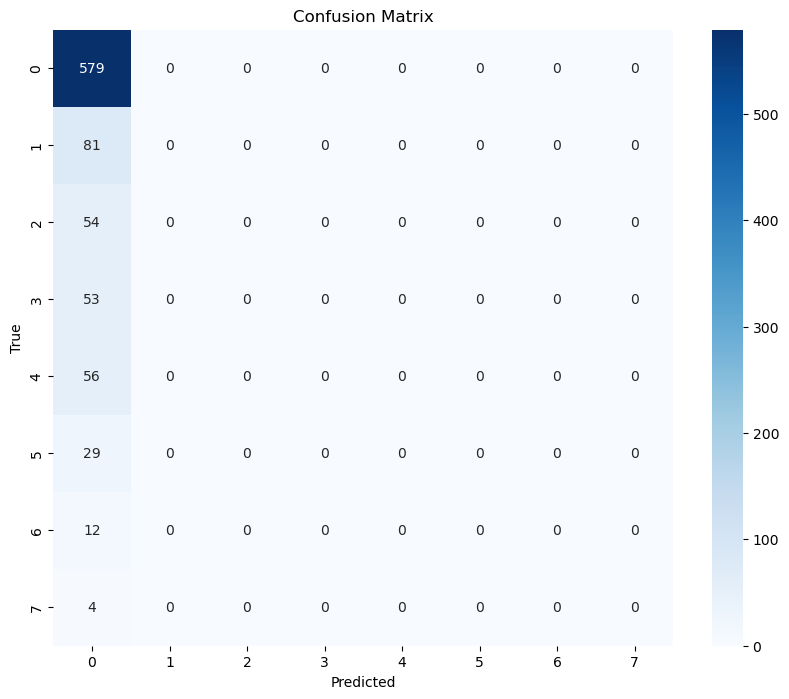

In [39]:
conf_matrix_mnb = confusion_matrix(y_test, y_pred_mnb)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_mnb, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [42]:
def acc(y_pred_best, y=y_test):
    accuracy = accuracy_score(y, y_pred_best)
    precision = precision_score(y, y_pred_best, average='weighted')  # or 'micro', 'macro', etc.
    recall = recall_score(y, y_pred_best, average='weighted')  # or 'micro', 'macro', etc.
    f1 = f1_score(y, y_pred_best, average='weighted')  # or 'micro', 'macro', etc.
    balanced_acc_best = balanced_accuracy_score(y, y_pred_best)

    print("Model evaluation")
    print(f'Akurasi           : {accuracy:.4f}')
    print(f'Precision         : {precision:.4f}')
    print(f'Recall            : {recall:.4f}')
    print(f'F1-Score          : {f1:.4f}')
    print(f"Balanced Accuracy : {balanced_acc_best:.4f}")
    
    
acc(y_pred_mnb) 

Model evaluation
Akurasi           : 0.6671
Precision         : 0.4450
Recall            : 0.6671
F1-Score          : 0.5338
Balanced Accuracy : 0.1250


/home/pityudhistira28/.conda/envs/dac/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Base Complement Naive Bayes (ComNB)

In [43]:
clf_cnb = Pipeline([
    ('vectorizer_tfid',TfidfVectorizer()),
    ('Complement NB',ComplementNB())
])

clf_cnb.fit(X_train, y_train)
y_pred_cnb = clf_cnb.predict(X_test)
print(classification_report(y_test, y_pred_cnb, zero_division=0))

              precision    recall  f1-score   support

           0       0.72      0.97      0.83       579
           1       0.54      0.17      0.26        81
           2       0.58      0.20      0.30        54
           3       0.79      0.21      0.33        53
           4       0.81      0.30      0.44        56
           5       0.14      0.03      0.06        29
           6       0.33      0.08      0.13        12
           7       0.00      0.00      0.00         4

    accuracy                           0.71       868
   macro avg       0.49      0.25      0.29       868
weighted avg       0.68      0.71      0.65       868



In [44]:
balanced_acc = balanced_accuracy_score(y_test, y_pred_cnb)
print("Balanced Accuracy: {:.2f}".format(balanced_acc))

Balanced Accuracy: 0.25


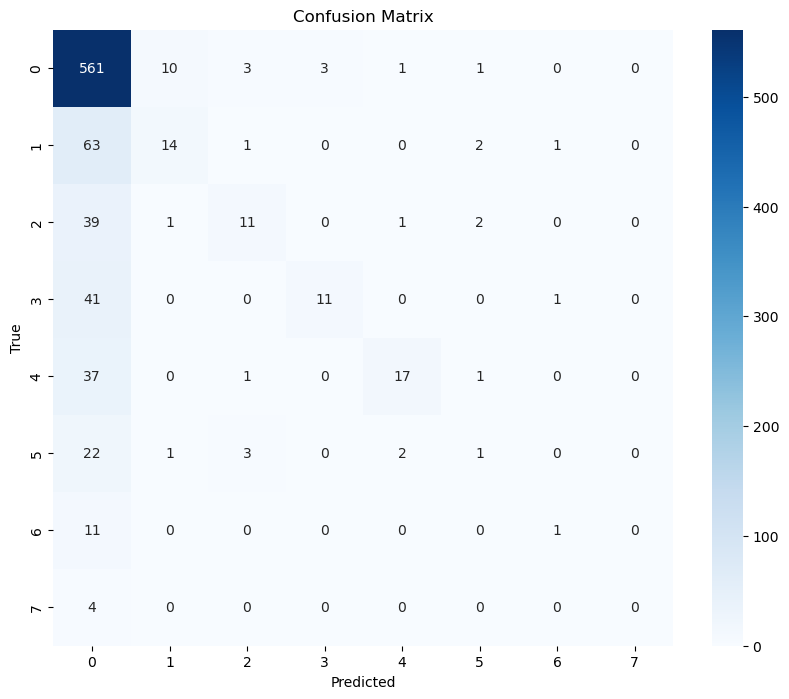

In [45]:
conf_matrix_cnb = confusion_matrix(y_test, y_pred_cnb)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_cnb, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [46]:
acc(y_pred_cnb)

Model evaluation
Akurasi           : 0.7097
Precision         : 0.6768
Recall            : 0.7097
F1-Score          : 0.6469
Balanced Accuracy : 0.2468


/home/pityudhistira28/.conda/envs/dac/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## SMOTE MultiNB

              precision    recall  f1-score   support

           0       0.86      0.53      0.66       579
           1       0.36      0.53      0.43        81
           2       0.37      0.70      0.48        54
           3       0.30      0.51      0.38        53
           4       0.33      0.59      0.42        56
           5       0.27      0.55      0.36        29
           6       0.11      0.25      0.15        12
           7       0.00      0.00      0.00         4

    accuracy                           0.54       868
   macro avg       0.33      0.46      0.36       868
weighted avg       0.68      0.54      0.57       868

Balanced Accuracy: 0.46
Confusion Matrix:
 [[309  55  56  53  53  27  19   7]
 [ 16  43   4   4   5   5   3   1]
 [  6   1  38   3   1   3   0   2]
 [ 14   4   0  27   6   0   2   0]
 [  4   6   3   2  33   8   0   0]
 [  4   3   2   1   3  16   0   0]
 [  6   3   0   0   0   0   3   0]
 [  1   3   0   0   0   0   0   0]]


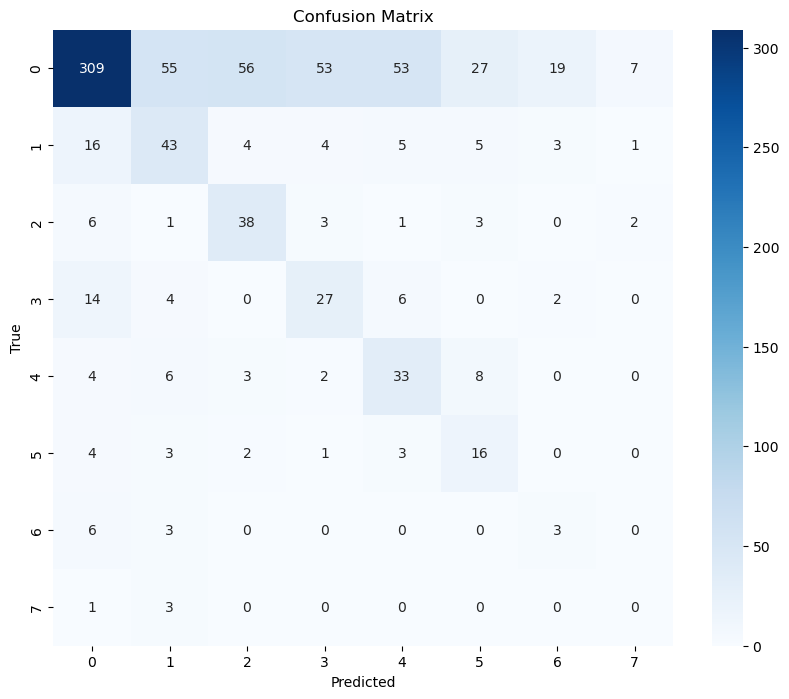

In [47]:
clf_mnb_smote = Pipeline([
    ('vectorizer_tfid', TfidfVectorizer()),
    ('smote', SMOTE(random_state=42)),
    ('Multi NB', MultinomialNB())
])

clf_mnb_smote.fit(X_train, y_train)
y_pred_mnb_smote = clf_mnb_smote.predict(X_test)

print(classification_report(y_test, y_pred_mnb_smote, zero_division=0))

balanced_acc = balanced_accuracy_score(y_test, y_pred_mnb_smote)
print("Balanced Accuracy: {:.2f}".format(balanced_acc))

conf_matrix_mnb_smote = confusion_matrix(y_test, y_pred_mnb_smote)
print("Confusion Matrix:\n", conf_matrix_mnb_smote)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_mnb_smote, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [48]:
scores_mnb_smote = cross_val_score(clf_mnb_smote, train_df.stemmed_text, train_df.encoded_label, cv=20, scoring='balanced_accuracy')
print("Cross-validation scores with balanced accuracy:", scores_mnb_smote)
print("Average balanced accuracy score:", scores_mnb_smote.mean())

Cross-validation scores with balanced accuracy: [0.50076931 0.50463559 0.48223825 0.39889538 0.54109241 0.54189179
 0.36008089 0.42867879 0.49729301 0.5043135  0.44279162 0.48824286
 0.38976175 0.44088196 0.43441802 0.59237085 0.4330444  0.4679503
 0.45302514 0.49079118]
Average balanced accuracy score: 0.46965834991158256


In [49]:
acc(y_pred_mnb_smote)

Model evaluation
Akurasi           : 0.5403
Precision         : 0.6795
Recall            : 0.5403
F1-Score          : 0.5739
Balanced Accuracy : 0.4586


## SMOTE ComNB

              precision    recall  f1-score   support

           0       0.88      0.38      0.53       579
           1       0.38      0.37      0.37        81
           2       0.32      0.78      0.45        54
           3       0.27      0.45      0.34        53
           4       0.30      0.64      0.41        56
           5       0.18      0.45      0.25        29
           6       0.11      0.75      0.20        12
           7       0.05      0.50      0.09         4

    accuracy                           0.44       868
   macro avg       0.31      0.54      0.33       868
weighted avg       0.69      0.44      0.48       868

Balanced Accuracy: 0.54
Confusion Matrix:
 [[222  39  74  57  68  41  49  29]
 [ 13  30   5   4   5   9  11   4]
 [  2   2  42   1   1   3   1   2]
 [  8   2   2  24   7   1   6   3]
 [  3   3   3   0  36   7   2   2]
 [  3   1   6   2   2  13   1   1]
 [  1   2   0   0   0   0   9   0]
 [  0   1   0   0   0   0   1   2]]


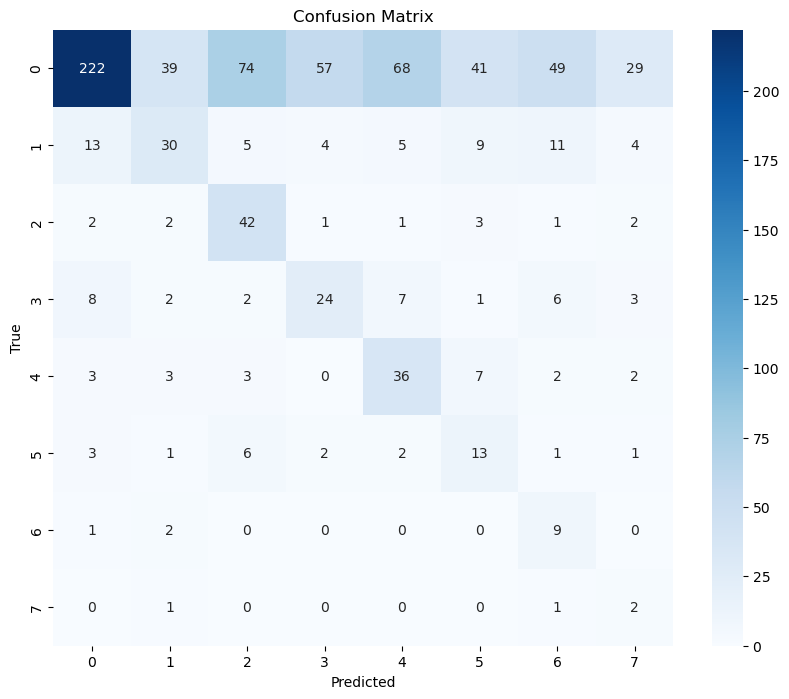

In [50]:
clf_cnb_smote = Pipeline([
    ('vectorizer_tfid', TfidfVectorizer()),
    ('smote', SMOTE(random_state=42)),
    ('Complement NB', ComplementNB())
])

clf_cnb_smote.fit(X_train, y_train)
y_pred_cnb_smote = clf_cnb_smote.predict(X_test)

print(classification_report(y_test, y_pred_cnb_smote, zero_division=0))

balanced_acc = balanced_accuracy_score(y_test, y_pred_cnb_smote)
print("Balanced Accuracy: {:.2f}".format(balanced_acc))

conf_matrix_cnb_smote = confusion_matrix(y_test, y_pred_cnb_smote)
print("Confusion Matrix:\n", conf_matrix_cnb_smote)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_cnb_smote, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [51]:
scores_cnb_smote = cross_val_score(clf_cnb_smote, train_df.stemmed_text, train_df.encoded_label, cv=20, scoring='balanced_accuracy')
print("Cross-validation scores with balanced accuracy:", scores_cnb_smote,)
print("Average balanced accuracy score:", scores_cnb_smote.mean())

Cross-validation scores with balanced accuracy: [0.5134643  0.4718821  0.4372062  0.47379617 0.46776938 0.46678495
 0.41153655 0.34698828 0.65630289 0.43409751 0.38355517 0.47639889
 0.34996211 0.56408678 0.47824934 0.59075092 0.40544714 0.42522894
 0.45678129 0.6305174 ]
Average balanced accuracy score: 0.4720403154077723


In [53]:
acc(y_pred_cnb_smote)

Model evaluation
Akurasi           : 0.4355
Precision         : 0.6862
Recall            : 0.4355
F1-Score          : 0.4781
Balanced Accuracy : 0.5407


## Hypertuning MNB

In [24]:
import optuna

/home/pityudhistira28/.conda/envs/dac/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [25]:
def objective(trial):
    # Define hyperparameter search space
    params = {
        'vectorizer_tfid__max_df': trial.suggest_float('max_df', 0.7, 1.0),
        'vectorizer_tfid__min_df': trial.suggest_int('min_df', 1, 5),
        'vectorizer_tfid__ngram_range': trial.suggest_categorical('ngram_range', [(1, 1), (1, 2), (1, 3)]),
        'Multi_NB__alpha': trial.suggest_float('alpha', 0.0001, 10.0, log=True),
        'Multi_NB__fit_prior': trial.suggest_categorical('fit_prior', [True, False]),
    }

    # Create pipeline with preprocessing, oversampling, and classifier
    clf = Pipeline([
        ('vectorizer_tfid', TfidfVectorizer()),
        ('smote', SMOTE(random_state=42)),
        ('Multi_NB', MultinomialNB())
    ])

    clf.set_params(**params)

    # Perform cross-validation
    y_pred = cross_val_predict(clf, X_train, y_train, cv=5)
    balanced_acc = balanced_accuracy_score(y_train, y_pred)
    return balanced_acc

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)  # Adjust the number of trials as needed

best_params_mnb = study.best_params
best_balanced_accuracy_mnb = study.best_value

print("Best Parameters:", best_params_mnb)
print("Best Balanced Accuracy:", best_balanced_accuracy_mnb)

[I 2024-11-29 03:58:15,845] A new study created in memory with name: no-name-e0ff7fc3-140b-4757-994b-0c4f0baa55ad
/home/pityudhistira28/.conda/envs/dac/lib/python3.12/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (1, 1) which is of type tuple.
  warnings.warn(message)
/home/pityudhistira28/.conda/envs/dac/lib/python3.12/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (1, 2) which is of type tuple.
  warnings.warn(message)
/home/pityudhistira28/.conda/envs/dac/lib/python3.12/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (1, 3) which is of type tuple.
  warnings.warn(message)
[I 2024-11

Best Parameters: {'max_df': 0.9068740562821911, 'min_df': 1, 'ngram_range': (1, 1), 'alpha': 7.351804042622549, 'fit_prior': True}
Best Balanced Accuracy: 0.4732910459026315


In [81]:
# best_params_mnb =  {'max_df': 0.9237638876910276, 'min_df': 1, 'ngram_range': (1, 1), 'alpha': 7.3173111395361365, 'fit_prior': False}
best_params_mnb = {'max_df': 0.9068740562821911, 'min_df': 1, 'ngram_range': (1, 1), 'alpha': 7.351804042622549, 'fit_prior': True}
clf_mnb_opt = Pipeline([
    ('vectorizer_tfid', TfidfVectorizer()),
    ('smote', SMOTE(random_state=42)),
    ('Multi_NB', MultinomialNB())
])

              precision    recall  f1-score   support

           0       0.90      0.34      0.49       579
           1       0.39      0.47      0.43        81
           2       0.31      0.72      0.43        54
           3       0.22      0.51      0.31        53
           4       0.27      0.61      0.38        56
           5       0.29      0.66      0.40        29
           6       0.11      0.67      0.18        12
           7       0.05      0.50      0.09         4

    accuracy                           0.42       868
   macro avg       0.32      0.56      0.34       868
weighted avg       0.70      0.42      0.45       868

Balanced Accuracy: 0.558320186165622


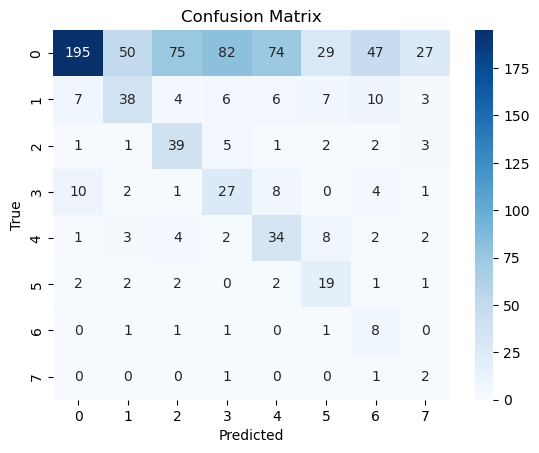

In [82]:
# Update the keys to match the pipeline structure
updated_best_params_mnb = {
    'vectorizer_tfid__max_df': best_params_mnb['max_df'],
    'vectorizer_tfid__min_df': best_params_mnb['min_df'],
    'vectorizer_tfid__ngram_range': best_params_mnb['ngram_range'],
    'Multi_NB__alpha': best_params_mnb['alpha'],
    'Multi_NB__fit_prior': best_params_mnb['fit_prior']
}

clf_mnb_opt.set_params(**updated_best_params_mnb)

# Fit on the entire training set
clf_mnb_opt.fit(X_train, y_train)

# Predict on the test set
y_pred_mnb_opt = clf_mnb_opt.predict(X_test)

# Evaluation
print(classification_report(y_test, y_pred_mnb_opt))
balanced_acc_mnb_opt = balanced_accuracy_score(y_test, y_pred_mnb_opt)
print("Balanced Accuracy:", balanced_acc_mnb_opt)

# Confusion Matrix
conf_matrix_mnb_opt = confusion_matrix(y_test, y_pred_mnb_opt)
sns.heatmap(conf_matrix_mnb_opt, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [83]:
scores_mnb_opt = cross_val_score(clf_mnb_opt, train_df.stemmed_text, train_df.encoded_label, cv=20, scoring='balanced_accuracy')
print("Cross-validation scores with balanced accuracy:", scores_mnb_opt)
print("Average balanced accuracy score:", scores_mnb_opt.mean())

Cross-validation scores with balanced accuracy: [0.49775878 0.5168064  0.50064866 0.4102545  0.50056662 0.52710241
 0.415356   0.40136968 0.61484227 0.45276462 0.4506505  0.47079544
 0.35845964 0.59790167 0.50671656 0.57958349 0.42727517 0.49961949
 0.47468817 0.63272546]
Average balanced accuracy score: 0.4917942764252031


In [84]:
acc(y_pred_mnb_opt)

Model evaluation
Akurasi           : 0.4171
Precision         : 0.7002
Recall            : 0.4171
F1-Score          : 0.4532
Balanced Accuracy : 0.5583


## Hypertuning CNB

In [29]:
def objective(trial):
    params = {
        'vectorizer_tfid__max_df': trial.suggest_float('max_df', 0.7, 1.0),
        'vectorizer_tfid__min_df': trial.suggest_int('min_df', 1, 5),
        'vectorizer_tfid__ngram_range': trial.suggest_categorical('ngram_range', [(1, 1), (1, 2), (1, 3)]),
        'Complement NB__alpha': trial.suggest_float('alpha', 0.0001, 10.0, log=True),
        'Complement NB__fit_prior': trial.suggest_categorical('fit_prior', [True, False])
    }

    clf = Pipeline([
        ('vectorizer_tfid', TfidfVectorizer()),
        ('smote', SMOTE(random_state=42)),
        ('Complement NB', ComplementNB())
    ])

    clf.set_params(**params)
    y_pred = cross_val_predict(clf, X_train, y_train, cv=5)
    balanced_acc = balanced_accuracy_score(y_train, y_pred)
    return balanced_acc

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)  # Adjust the number of trials as needed

best_params_cnb = study.best_params
best_balanced_accuracy_cnb = study.best_value

print("Best Parameters:", best_params_cnb)
print("Best Balanced Accuracy:", best_balanced_accuracy_cnb)

[I 2024-11-29 03:59:38,544] A new study created in memory with name: no-name-bb745337-a524-4285-838f-dae02819d88b
/home/pityudhistira28/.conda/envs/dac/lib/python3.12/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (1, 1) which is of type tuple.
  warnings.warn(message)
/home/pityudhistira28/.conda/envs/dac/lib/python3.12/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (1, 2) which is of type tuple.
  warnings.warn(message)
/home/pityudhistira28/.conda/envs/dac/lib/python3.12/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (1, 3) which is of type tuple.
  warnings.warn(message)
[I 2024-11

Best Parameters: {'max_df': 0.9380095260973401, 'min_df': 4, 'ngram_range': (1, 1), 'alpha': 9.700160947414044, 'fit_prior': False}
Best Balanced Accuracy: 0.4903079974862308


In [88]:
# best_params_cnb = {'max_df': 0.7744025208958192, 'min_df': 4, 'ngram_range': (1, 1), 'alpha': 9.756233878254037, 'fit_prior': False}
best_params_cnb = {'max_df': 0.9380095260973401, 'min_df': 4, 'ngram_range': (1, 1), 'alpha': 9.700160947414044, 'fit_prior': False}


clf_cnb_opt = Pipeline([
    ('vectorizer_tfid', TfidfVectorizer()),
    ('smote', SMOTE(random_state=42)),
    ('Complement NB', ComplementNB())
])

              precision    recall  f1-score   support

           0       0.91      0.23      0.37       579
           1       0.38      0.37      0.37        81
           2       0.33      0.78      0.47        54
           3       0.27      0.55      0.36        53
           4       0.26      0.62      0.37        56
           5       0.21      0.55      0.30        29
           6       0.10      0.83      0.17        12
           7       0.02      0.50      0.04         4

    accuracy                           0.35       868
   macro avg       0.31      0.56      0.31       868
weighted avg       0.70      0.35      0.37       868

Balanced Accuracy: 0.5550328960264602


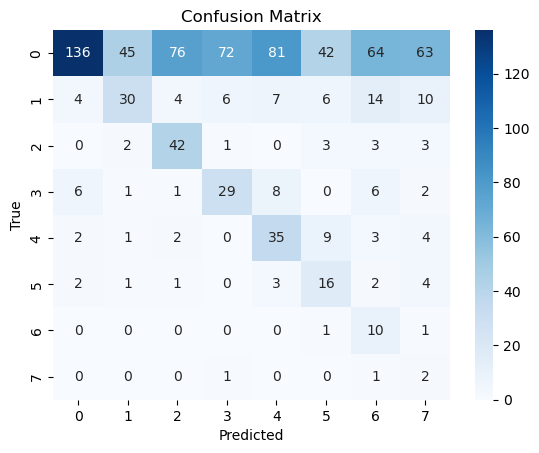

In [89]:
# Update the keys to match the pipeline structure
updated_best_params_cnb = {
    'vectorizer_tfid__max_df': best_params_cnb['max_df'],
    'vectorizer_tfid__min_df': best_params_cnb['min_df'],
    'vectorizer_tfid__ngram_range': best_params_cnb['ngram_range'],
    'Complement NB__alpha': best_params_cnb['alpha'],
    'Complement NB__fit_prior': best_params_cnb['fit_prior']
}

clf_cnb_opt.set_params(**updated_best_params_cnb)

# Fit on the entire training set
clf_cnb_opt.fit(X_train, y_train)

# Predict on the test set
y_pred_cnb_opt = clf_cnb_opt.predict(X_test)

# Evaluation
print(classification_report(y_test, y_pred_cnb_opt))
balanced_acc_cnb_opt = balanced_accuracy_score(y_test, y_pred_cnb_opt)
print("Balanced Accuracy:", balanced_acc_cnb_opt)

# Confusion Matrix
conf_matrix_cnb_opt = confusion_matrix(y_test, y_pred_cnb_opt)
sns.heatmap(conf_matrix_cnb_opt, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [90]:
scores_cnb_opt = cross_val_score(clf_cnb_opt, train_df.stemmed_text, train_df.encoded_label, cv=20, scoring='balanced_accuracy')
print("Cross-validation scores with balanced accuracy:", scores_cnb_opt)
print("Average balanced accuracy score:", scores_cnb_opt.mean())

Cross-validation scores with balanced accuracy: [0.5072664  0.491283   0.640894   0.44018239 0.53857028 0.5222413
 0.43362714 0.35700392 0.62875932 0.44492311 0.45063155 0.48349043
 0.44936529 0.54649488 0.59196034 0.58304282 0.55085891 0.4265173
 0.44964791 0.63309492]
Average balanced accuracy score: 0.5084927608311228


In [91]:
acc(y_pred_cnb_opt)

Model evaluation
Akurasi           : 0.3456
Precision         : 0.7020
Recall            : 0.3456
F1-Score          : 0.3710
Balanced Accuracy : 0.5550


## Random Oversampler Optuna MNB

In [33]:
def objective(trial):
    # Define hyperparameter search space
    params = {
        'vectorizer_tfid__max_df': trial.suggest_float('max_df', 0.7, 1.0),
        'vectorizer_tfid__min_df': trial.suggest_int('min_df', 1, 5),
        'vectorizer_tfid__ngram_range': trial.suggest_categorical('ngram_range', [(1, 1), (1, 2), (1, 3)]),
        'Multi_NB__alpha': trial.suggest_float('alpha', 0.0001, 10.0, log=True),
        'Multi_NB__fit_prior': trial.suggest_categorical('fit_prior', [True, False]),
    }

    # Create pipeline with preprocessing, oversampling, and classifier
    clf = Pipeline([
        ('vectorizer_tfid', TfidfVectorizer()),
        ('ros', RandomOverSampler(random_state=42)),
        ('Multi_NB', MultinomialNB())
    ])

    clf.set_params(**params)

    # Perform cross-validation
    y_pred = cross_val_predict(clf, X_train, y_train, cv=5)
    balanced_acc = balanced_accuracy_score(y_train, y_pred)
    return balanced_acc

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)  # Adjust the number of trials as needed

best_params_ro_mnb = study.best_params
best_balanced_accuracy_ro_mnb = study.best_value

print("Best Parameters:", best_params_ro_mnb)
print("Best Balanced Accuracy:", best_balanced_accuracy_ro_mnb)

[I 2024-11-29 04:00:43,585] A new study created in memory with name: no-name-765f6cb3-cfa1-4118-9c33-37767ab86b03
/home/pityudhistira28/.conda/envs/dac/lib/python3.12/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (1, 1) which is of type tuple.
  warnings.warn(message)
/home/pityudhistira28/.conda/envs/dac/lib/python3.12/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (1, 2) which is of type tuple.
  warnings.warn(message)
/home/pityudhistira28/.conda/envs/dac/lib/python3.12/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (1, 3) which is of type tuple.
  warnings.warn(message)
[I 2024-11

Best Parameters: {'max_df': 0.9707041177690289, 'min_df': 1, 'ngram_range': (1, 3), 'alpha': 4.4456257942674275, 'fit_prior': False}
Best Balanced Accuracy: 0.4723408171458854


In [63]:
best_params_ro_mnb_opt = {'max_df': 0.9312048586185621, 'min_df': 1, 'ngram_range': (1, 3), 'alpha': 4.316763868716976, 'fit_prior': False}

clf_ro_mnb_opt = Pipeline([
    ('vectorizer_tfid', TfidfVectorizer()),
    ('ros', RandomOverSampler(random_state=42)),
    ('Multi_NB', MultinomialNB())
])

              precision    recall  f1-score   support

           0       0.89      0.29      0.44       579
           1       0.38      0.54      0.45        81
           2       0.32      0.76      0.45        54
           3       0.26      0.49      0.34        53
           4       0.24      0.59      0.35        56
           5       0.18      0.41      0.26        29
           6       0.10      0.67      0.17        12
           7       0.04      0.50      0.08         4

    accuracy                           0.39       868
   macro avg       0.30      0.53      0.32       868
weighted avg       0.68      0.39      0.42       868

Balanced Accuracy: 0.5320487912233736


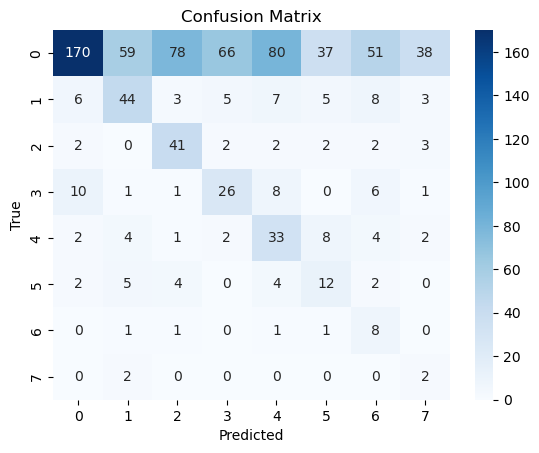

In [64]:
# Update the keys to match the pipeline structure
updated_best_params_ro_mnb_opt = {
    'vectorizer_tfid__max_df': best_params_ro_mnb_opt['max_df'],
    'vectorizer_tfid__min_df': best_params_ro_mnb_opt['min_df'],
    'vectorizer_tfid__ngram_range': best_params_ro_mnb_opt['ngram_range'],
    'Multi_NB__alpha': best_params_ro_mnb_opt['alpha'],
    'Multi_NB__fit_prior': best_params_ro_mnb_opt['fit_prior']
}

clf_ro_mnb_opt.set_params(**updated_best_params_ro_mnb_opt)

# Fit on the entire training set
clf_ro_mnb_opt.fit(X_train, y_train)

# Predict on the test set
y_pred_ro_mnb_opt = clf_ro_mnb_opt.predict(X_test)

# Evaluation
print(classification_report(y_test, y_pred_ro_mnb_opt))
balanced_acc_ro_mnb_opt = balanced_accuracy_score(y_test, y_pred_ro_mnb_opt)
print("Balanced Accuracy:", balanced_acc_ro_mnb_opt)

# Confusion Matrix
conf_matrix_ro_mnb_opt = confusion_matrix(y_test, y_pred_ro_mnb_opt)
sns.heatmap(conf_matrix_ro_mnb_opt, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [65]:
scores_ro_mnb_opt = cross_val_score(clf_ro_mnb_opt, train_df.stemmed_text, train_df.encoded_label, cv=20, scoring='balanced_accuracy')
print("Cross-validation scores with balanced accuracy:", scores_ro_mnb_opt)
print("Average balanced accuracy score:", scores_ro_mnb_opt.mean())

Cross-validation scores with balanced accuracy: [0.53538548 0.47752305 0.51459669 0.38103823 0.4888679  0.49319864
 0.41162813 0.45562871 0.65580949 0.44065539 0.4456936  0.6147207
 0.38123105 0.56439466 0.49430024 0.4140473  0.39308134 0.44950739
 0.43211681 0.67407162]
Average balanced accuracy score: 0.485874821718033


In [66]:
acc(y_pred_ro_mnb_opt)

Model evaluation
Akurasi           : 0.3871
Precision         : 0.6850
Recall            : 0.3871
F1-Score          : 0.4179
Balanced Accuracy : 0.5320


## Random Oversampler Optuna CNB

In [37]:
def objective(trial):
    # Define hyperparameter search space
    params = {
        'vectorizer_tfid__max_df': trial.suggest_float('max_df', 0.7, 1.0),
        'vectorizer_tfid__min_df': trial.suggest_int('min_df', 1, 5),
        'vectorizer_tfid__ngram_range': trial.suggest_categorical('ngram_range', [(1, 1), (1, 2), (1, 3)]),
        'Complement NB__alpha': trial.suggest_float('alpha', 0.0001, 10.0, log=True),  # Corrected line
        'Complement NB__fit_prior': trial.suggest_categorical('fit_prior', [True, False]),  # Corrected line
    }

    # Create pipeline with preprocessing, oversampling, and classifier
    clf = Pipeline([
        ('vectorizer_tfid', TfidfVectorizer()),
        ('ros', RandomOverSampler(random_state=42)),
        ('Complement NB', ComplementNB())  # Ensure this name matches in set_params
    ])

    clf.set_params(**params)

    # Perform cross-validation
    y_pred = cross_val_predict(clf, X_train, y_train, cv=5)
    balanced_acc = balanced_accuracy_score(y_train, y_pred)
    return balanced_acc

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)  # Adjust the number of trials as needed

best_params_ro_cnb = study.best_params
best_balanced_accuracy_ro_cnb = study.best_value

print("Best Parameters:", best_params_ro_cnb)
print("Best Balanced Accuracy:", best_balanced_accuracy_ro_cnb)

[I 2024-11-29 04:02:30,180] A new study created in memory with name: no-name-b4885a09-cace-4cb0-bfdd-1ac888ca0dd0
/home/pityudhistira28/.conda/envs/dac/lib/python3.12/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (1, 1) which is of type tuple.
  warnings.warn(message)
/home/pityudhistira28/.conda/envs/dac/lib/python3.12/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (1, 2) which is of type tuple.
  warnings.warn(message)
/home/pityudhistira28/.conda/envs/dac/lib/python3.12/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (1, 3) which is of type tuple.
  warnings.warn(message)
[I 2024-11

Best Parameters: {'max_df': 0.9395718982588545, 'min_df': 3, 'ngram_range': (1, 1), 'alpha': 1.5382822193624057, 'fit_prior': False}
Best Balanced Accuracy: 0.49312303473568336


In [67]:
best_params_ro_cnb_opt = {'max_df': 0.8372229924416903, 'min_df': 3, 'ngram_range': (1, 1), 'alpha': 3.167927784085363, 'fit_prior': False}

clf_ro_cnb_opt = Pipeline([
    ('vectorizer_tfid', TfidfVectorizer()),
    ('ros', RandomOverSampler(random_state=42)),
    ('Complement NB', ComplementNB())
])

              precision    recall  f1-score   support

           0       0.90      0.28      0.43       579
           1       0.36      0.37      0.36        81
           2       0.32      0.78      0.45        54
           3       0.30      0.51      0.38        53
           4       0.28      0.68      0.40        56
           5       0.14      0.41      0.21        29
           6       0.10      0.75      0.17        12
           7       0.03      0.50      0.06         4

    accuracy                           0.37       868
   macro avg       0.30      0.53      0.31       868
weighted avg       0.69      0.37      0.40       868

Balanced Accuracy: 0.5349674235682491


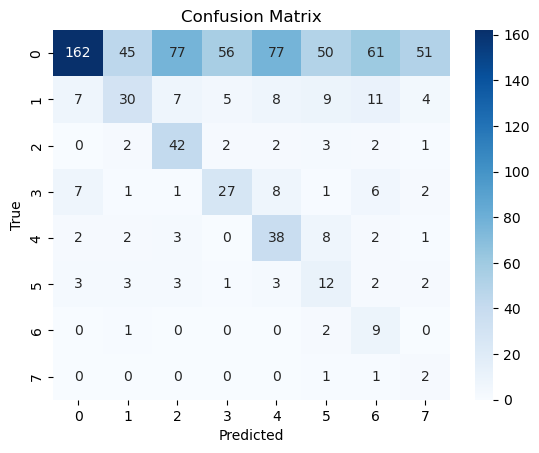

In [68]:
# Update the keys to match the pipeline structure
updated_best_params_ro_cnb_opt = {
    'vectorizer_tfid__max_df': best_params_ro_cnb_opt['max_df'],
    'vectorizer_tfid__min_df': best_params_ro_cnb_opt['min_df'],
    'vectorizer_tfid__ngram_range': best_params_ro_cnb_opt['ngram_range'],
    'Complement NB__alpha': best_params_ro_cnb_opt['alpha'],
    'Complement NB__fit_prior': best_params_ro_cnb_opt['fit_prior']
}

clf_ro_cnb_opt.set_params(**updated_best_params_ro_cnb_opt)

# Fit on the entire training set
clf_ro_cnb_opt.fit(X_train, y_train)

# Predict on the test set
y_pred_ro_cnb_opt = clf_ro_cnb_opt.predict(X_test)

# Evaluation
print(classification_report(y_test, y_pred_ro_cnb_opt))
balanced_acc_ro_cnb_opt = balanced_accuracy_score(y_test, y_pred_ro_cnb_opt)
print("Balanced Accuracy:", balanced_acc_ro_cnb_opt)

# Confusion Matrix
conf_matrix_ro_cnb_opt = confusion_matrix(y_test, y_pred_ro_cnb_opt)
sns.heatmap(conf_matrix_ro_cnb_opt, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [69]:
scores_ro_cnb_opt = cross_val_score(clf_ro_cnb_opt, train_df.stemmed_text, train_df.encoded_label, cv=20, scoring='balanced_accuracy')
print("Cross-validation scores with balanced accuracy:", scores_ro_cnb_opt)
print("Average balanced accuracy score:", scores_ro_cnb_opt.mean())

Cross-validation scores with balanced accuracy: [0.49806429 0.51954733 0.49124122 0.47411859 0.50013545 0.48693147
 0.40563378 0.38861153 0.61669903 0.43587138 0.44428919 0.47292061
 0.34855532 0.56564671 0.44379816 0.59050461 0.406145   0.4281625
 0.44779115 0.66426203]
Average balanced accuracy score: 0.4814464687013179


In [70]:
acc(y_pred_ro_cnb_opt)

Model evaluation
Akurasi           : 0.3710
Precision         : 0.6923
Recall            : 0.3710
F1-Score          : 0.4043
Balanced Accuracy : 0.5350


# Evaluation

After several round of Optuna hypertuning, the best model's is SMOTE Complement Naive Bayes using SMOTE, based on their cross validation and balanced accuracy metric. Let's see in detail.

best parameter fr Complement Naive Bayes:

{'max_df': 0.8981026022043065, 'min_df': 2, 'ngram_range': (1, 2), 'alpha': 7.09904501602026, 'fit_prior': False}

In [71]:
base_parameter = {'max_df': 0.8981026022043065, 'min_df': 2, 'ngram_range': (1, 2), 'alpha': 7.09904501602026, 'fit_prior': False}

In [72]:
best_clf = Pipeline([
    ('vectorizer_tfid', TfidfVectorizer()),
    ('smote', SMOTE(random_state=42)),
    ('Complement NB', ComplementNB())
])

In [73]:
updated_best_params = {
    'vectorizer_tfid__max_df': base_parameter['max_df'],
    'vectorizer_tfid__min_df': base_parameter['min_df'],
    'vectorizer_tfid__ngram_range': base_parameter['ngram_range'],
    'Complement NB__alpha': base_parameter['alpha'],
    'Complement NB__fit_prior': base_parameter['fit_prior']
}

best_clf.set_params(**updated_best_params)

Pipeline(steps=[('vectorizer_tfid',
                 TfidfVectorizer(max_df=0.8981026022043065, min_df=2,
                                 ngram_range=(1, 2))),
                ('smote', SMOTE(random_state=42)),
                ('Complement NB',
                 ComplementNB(alpha=7.09904501602026, fit_prior=False))])

## Metric Evaluation

In [74]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, roc_curve, auc

In [75]:
X = train_df.stemmed_text
y = train_df.encoded_label

best_clf.fit(X, y)

Pipeline(steps=[('vectorizer_tfid',
                 TfidfVectorizer(max_df=0.8981026022043065, min_df=2,
                                 ngram_range=(1, 2))),
                ('smote', SMOTE(random_state=42)),
                ('Complement NB',
                 ComplementNB(alpha=7.09904501602026, fit_prior=False))])

In [78]:
X = train_df.stemmed_text
y = train_df.encoded_label

best_clf.fit(X, y)

y_pred_best = cross_val_predict(best_clf, X, y, cv=5)

In [79]:
accuracy = accuracy_score(y, y_pred_best)
precision = precision_score(y, y_pred_best, average='weighted')  # or 'micro', 'macro', etc.
recall = recall_score(y, y_pred_best, average='weighted')  # or 'micro', 'macro', etc.
f1 = f1_score(y, y_pred_best, average='weighted')  # or 'micro', 'macro', etc.
balanced_acc_best = balanced_accuracy_score(y, y_pred_best)

print("Model evaluation")
print(f'Akurasi           : {accuracy:.4f}')
print(f'Precision         : {precision:.4f}')
print(f'Recall            : {recall:.4f}')
print(f'F1-Score          : {f1:.4f}')
print(f"Balanced Accuracy : {balanced_acc_best:.4f}")

Model evaluation
Akurasi           : 0.3677
Precision         : 0.7052
Recall            : 0.3677
F1-Score          : 0.4026
Balanced Accuracy : 0.4932


In [80]:
scores_best = cross_val_score(best_clf, train_df.stemmed_text, train_df.encoded_label, cv=20, scoring='balanced_accuracy')
print("Cross-validation scores with balanced accuracy:", scores_best)
print("Average balanced accuracy score:", scores_best.mean())

Cross-validation scores with balanced accuracy: [0.50080089 0.47409964 0.49544032 0.43855311 0.50498893 0.47703564
 0.40188111 0.43527773 0.63844812 0.4740803  0.43268204 0.61953391
 0.48760421 0.55577397 0.48597638 0.55892541 0.54124353 0.43147499
 0.472533   0.66089428]
Average balanced accuracy score: 0.5043623755315567


Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.27      0.42      2895
           1       0.32      0.41      0.36       405
           2       0.31      0.76      0.44       270
           3       0.22      0.49      0.30       263
           4       0.34      0.70      0.46       278
           5       0.19      0.46      0.27       147
           6       0.08      0.50      0.13        60
           7       0.02      0.35      0.03        20

    accuracy                           0.37      4338
   macro avg       0.30      0.49      0.30      4338
weighted avg       0.71      0.37      0.40      4338



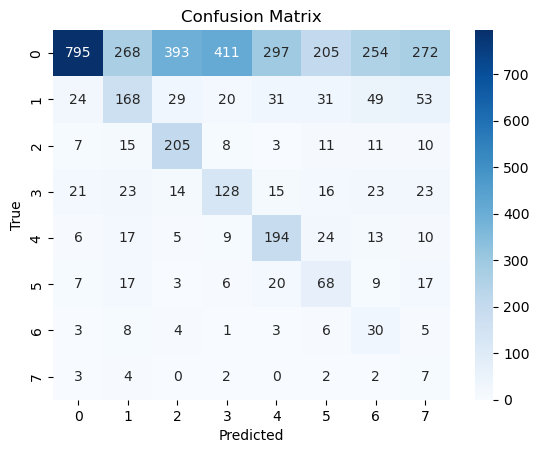

In [117]:
print("Classification Report:")
print(classification_report(y, y_pred_best))

# Confusion Matrix
conf_matrix_best = confusion_matrix(y, y_pred_best)
sns.heatmap(conf_matrix_best, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
scores_best = cross_val_score(best_clf, train_df.stemmed_text, train_df.encoded_label, cv=20, scoring='balanced_accuracy')
print("Cross-validation scores with balanced accuracy:", scores_best)
print("Average balanced accuracy score:", scores_best.mean())

In [56]:
encoding_dict = {
    0:'Politik',
    1:'Sosial Budaya',
    2:'Pertahanan dan Keamanan',
    3:'Ideologi',
    4:'Ekonomi',
    5:'Sumber Daya Alam',
    6:'Demografi',
    7:'Geografi',
}

In [57]:
pd.Series(y_pred).map(encoding_dict).value_counts()

Politik                    866
Pertahanan dan Keamanan    653
Ideologi                   585
Ekonomi                    563
Sosial Budaya              520
Geografi                   397
Demografi                  391
Sumber Daya Alam           363
Name: count, dtype: int64